In [1]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import zillow
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import json
import geog
import shapely.geometry
pd.options.display.max_rows = 700

In [2]:
from zillow import ValuationApi

#insert your API key from zillow here
zid = 'X1-ZWz18cqbc8wgsr_7j3qs'

api = zillow.ValuationApi()

In [3]:
df = pd.read_csv('./us/ny/statewide.csv')

# Generate the Polygon
This function generates the circle polygon as the selector.

In [4]:
def circle_area(long,lat,radius,n_points):
    p = shapely.geometry.Point([long, lat])
    angles = np.linspace(0, 360, n_points)
    d = radius
    polygon = geog.propagate(p, angles, d)
    df_test = pd.DataFrame(polygon)
    polygon = shapely.geometry.mapping(shapely.geometry.Polygon(polygon))
    df_test.plot(x = 0, y = 1, kind = 'scatter')
    return polygon

This step is important becuase it establishes the produced circle as a GeoPandas Polygon, this will be used later to determine the values within the given area.

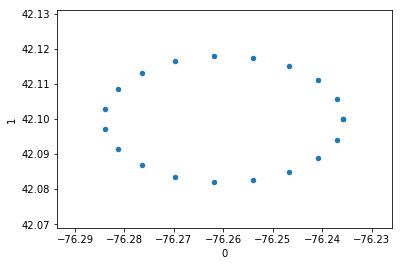

In [5]:
polygon =circle_area(-76.26,42.1,2000,n_points=20)
poly = Polygon(polygon['coordinates'][0])

# Cleaning
Below are the few steps taken to clean the data.  The first is a simple drop/drop na, removing non-essential columns and removing rows with NaN information (notably, 'STREET' or street names and 'NUMBERS' or house numbers)

In [5]:
df.drop(['DISTRICT','REGION','ID','HASH','UNIT'], axis = 1, inplace = True)
df.dropna(inplace = True)
df.reset_index(inplace = True)
#df['POSTCODE'] = df['POSTCODE'].astype(int)
df['POSTCODE'] = df['POSTCODE'].astype(str)


In [6]:
#df['POSTCODE'] = df['POSTCODE'].apply(lambda x: x.zfill(5))

Instantiate the progress bar, this helps keep and eye on the for loops as they run. A common error is having to rerun the bar each loop, not necesary but helpful for watching the loop and ETA

In [7]:
from progressbar import ProgressBar
bar = ProgressBar(poll_interval=1)

In [8]:
pointlist = []
for i in bar(range(len(df))):
    pointlist.append(Point(df['LON'].iloc[i],df['LAT'].iloc[i]))

 83% (4389773 of 5252595) |###########   | Elapsed Time: 0:04:41 ETA:   0:00:54

KeyboardInterrupt: 

In [ ]:
bar = ProgressBar(poll_interval=1)

In [ ]:
temp_list = []
for i in bar(pointlist):
        if poly.contains(i) == True:
            temp_list.append(df.iloc[pointlist.index(i)])
print(temp_list)

In [133]:
zdf = pd.DataFrame(temp_list)
zdf.reset_index(inplace = True)

In [137]:
from progressbar import ProgressBar
bar = ProgressBar(poll_interval=1)

In [135]:
def Zestimate():
    zestimate_list = []
    #zipdf = df[df['POSTCODE'].isin(zipcode)]
    zipdf = zdf

    for i in bar(range(len(zipdf))):
        try:
            address = str(zipdf['NUMBER'][i]+' '+zipdf['STREET'][i]+'.,'+zipdf['CITY'][i]+', FL')
            postal_code = str(zipdf['POSTCODE'][i])
            data = api.GetSearchResults(zid,address,postal_code)
            if data != None:
                zestimate_list.append(data.zestiamte.amount)
            else:
                pass
        except:
            pass
    #Worth noting that many of the addresses do no have corresponding values in the zillow database.
    #The below print output shows how many the API missed.
    print('Missing Values:',len(zipdf)-len(zestimate_list),'Gathered %:',(len(zestimate_list))/len(zipdf))
    
    # This is the print output, change the print out to your preference.
    zestimate_list = [x for x in zestimate_list if x is not None]
    zestimate_list = np.array(zestimate_list)
    statistics = stats.describe(zestimate_list)
    std = np.std(zestimate_list)
    median = np.median(zestimate_list)
    print('    ==========================================')
    print('                 For Area', )
    print('    ==========================================')
    print()
    print('     |  Values  |:',statistics[0])
    print('     | Minimum  |:', statistics[1][0])
    print('     | Maximum  |:', statistics[1][1])
    print('     |  Median  |:', median)
    print('     |   Mean   |:', float("{0:.2f}".format(statistics[2])))
    print('     |   Std    |:', float("{0:.2f}".format(std)))
    print('     | Skewness |:', float("{0:.2f}".format(statistics[4])))
    print('     | Kurtosis |:', float("{0:.2f}".format(statistics[5])))
    plt.hist(zestimate_list, edgecolor = 'black');
    plt.xlabel('House Value')
    plt.ylabel('Frequency')
    return 

In [138]:
Zestimate()

100% (2124 of 2124) |####################| Elapsed Time: 0:06:08 Time:  0:06:08


Missing Values: 2124 Gathered %: 0.0


ValueError: The input must not be empty.